In [1]:
# So I think we could just use scipy's integrator for the electronic dofs and verlet for the nucelar dofs.
# use the same model potential as in the fssh notebook to make a comparison.

import numpy as np
from math import pi
from ipywidgets import Button, FloatSlider, HBox, VBox, IntProgress,Output
from ipywidgets import Dropdown, Layout, Accordion, Label
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import animation
from datetime import datetime
import math
import scipy.integrate
%matplotlib notebook
pause = False
output = Output(layout=Layout(width="400px"))
N_trajs = 100
step=0
######################################################################
# Set up plot

######################################################################
# Create the animation

# specify time steps and duration


# Tully 1 for starters
class tully1:
    def __init__(self, A = 0.01, B = 1.6, C = 0.005, D = 1.0):
        self.A = A
        self.B = B
        self.C = C
        self.D = D

    def V(self,x):
        if x > 0:
            v11 = self.A* ( 1.0 - np.exp(-self.B *x) )
        else:
            v11 = -self.A* ( 1.0 - np.exp(self.B *x) )
        v22 = -v11
        v12 = self.C * np.exp(-self.D*x**2)
        V_ = np.array([[v11, v12], [v12, v22]])
        return V_

    def dV(self, x):
        v11 = self.A * self.B * np.exp(-self.B * abs(x))
        v22 = -v11
        v12 = -2.0 * self.C * self.D * x * np.exp(-self.D *x**2)
        dV_ = np.array([[v11, v12], [v12, v22]])
        return dV_


class FSSH:
        def __init__(self, model, nuc_pos, vel, mass, dt):

            self.time = 0.
            self.model = model
            self.nuc_pos = nuc_pos
            self.nstates=2
            self.dt = dt
            self.mass = mass
            self.vel = vel
            self.F = 0. # force
            self.accel = 0.
            self.V = self.model.V
            self.dV = self.model.dV
            self.ke = 0.
            self.pe = 0.
            self.tot_e = 0.
            self.elec_energies, self.evecs = np.linalg.eigh(self.V(self.nuc_pos))
            self.elec_coeffs = np.array([1,0])
            self.rho  = np.zeros([2,2], dtype = np.complex64)
            self.rho[0,0]=1.
            self.current_state = 0
            self.p1 = np.real(self.rho[0,0])
            self.p2 = np.real(self.rho[1,1])
            self.dij = np.zeros((2,2))
            self.nac_mat = np.zeros((2,2))
            self.P=0. # hopping probabiity 
            # if ref_coeff is not None:
            #     for mo in range(self.nstates()):
            #         if (np.dot(self.coeff[:,mo], ref_coeff[:,mo]) < 0.0):
            #             self.coeff[:,mo] *= -1.0


        def diag_Vmat(self):
            #     print(V)
            self.elec_energies, self.evecs = np.linalg.eigh(self.V(self.nuc_pos))

        def getHFforce(self):

            force = 0.
            dV = self.dV(self.nuc_pos)
            ket = self.evecs[:,self.current_state]
            bra = np.conj(ket)
            force = -(np.dot(bra, np.dot(dV,ket)))
                    
            self.F = np.real(force)
          
        def rescale_ke(self,reduction):
            # normalize

            a = self.mass**2
            b = 2.0 *self.mass**2 * self.vel
            c = -2.0 * self.mass * reduction
            roots = np.roots([a, b, c])
            scal = min(roots, key=lambda x: abs(x))
            self.vel += scal 
            
        def hop(self):
           
#             c_1 = self.elec_coeffs[0] 
#             c_2 = self.elec_coeffs[1]
#             rho[0,0] = c_1*np.conj(c_1)
#             rho[1,0] = np.conj(c_1)*c_2
#             rho[0,1] = np.conj(c_2)*c_1
#             rho[1,1] = np.conj(c_2)*c_2
            
           
            proposed_state = 1-self.current_state
          
            self.compute_couplings(proposed_state, self.current_state)        
          
            bij = -2.0 * np.real(self.rho[self.current_state, proposed_state])*self.vel*self.dij[proposed_state,self.current_state]

            #print("np.real(rho[current_state, proposed_state]) = {}".format(np.real(rho[current_state, proposed_state])))
            # probability of hopping from current state
            if bij >0:
                self.P = self.dt * bij / np.real(self.rho[self.current_state, self.current_state])
            else:
                self.P=0.
            zeta = np.random.uniform()
        
            if zeta < self.P:
#                 with output:
#                     print("zeta = {} self.P = {}".format(zeta,self.P))
                #  this will only work for a two-state model
                new_potential, old_potential = self.elec_energies[proposed_state], self.elec_energies[self.current_state]
                delta_V = new_potential - old_potential
                self.calc_kinetic_energy()
                if delta_V <= self.ke:
                    self.current_state = proposed_state
                    self.rescale_ke(-delta_V)

            
        def run_single_step(self):
                    
            self.nuc_pos += self.vel*self.dt
            self.diag_Vmat()           
            self.getHFforce()           
            self.accel = self.F/self.mass
            self.vel += self.accel*self.dt
            self.elec_prop()
            
            self.hop()
           
            self.time += self.dt
            # compute observables
            self.compute_pops()
            self.calc_pe()
            self.calc_kinetic_energy()
            self.calc_total_energy()
                        

       
        def calc_kinetic_energy(self):
            self.ke= 0.5 * self.mass * self.vel**2
        
        def calc_pe(self):
            self.pe = self.elec_energies[self.current_state]
            
        def calc_total_energy(self):
            self.tot_e = self.ke + self.pe


        def compute_couplings(self,i,j):
            
            dV = self.dV(self.nuc_pos)
            if (i != j):
        
                self.dij[i,j] = np.dot(np.conj(self.evecs[:,i]), np.dot(dV[:,:], self.evecs[:,j]))
              
                #                dij = np.outer(elec_coeffs, dV@elec_coeffs)[i][j]
                dE = self.elec_energies[j] - self.elec_energies[i]
                if abs(dE) < 1.0e-14:
                    if dE < 0:
                        dE = -1.0e-14
                    else:
                        dE = 1.0e-14
                self.dij[i,j] = self.dij[i,j] / dE


        def compute_nac(self):
            nac_mat = np.zeros([2,2], dtype=np.complex64)
            for i in range(2):
                for j in range(i):
                    self.compute_couplings(i,j)
                    #print("vel = {}".format(vel))
                    self.nac_mat[i, j] = self.vel*self.dij[i,j]
                    self.nac_mat[j, i] = - self.nac_mat[i, j]

        def compute_pops(self):
            self.p1 = np.real(self.rho[0,0])
            self.p2 = np.real(self.rho[1,1])

#         def elec_prop(self):
            
#             # evolve electron coefficients for a time dt
#             self.compute_nac()
#             V = self.V(self.nuc_pos)
#             def dc(time, y):
                
#                 d_c = -1j*np.dot(V, y) - np.dot(self.nac_mat,y)
#                 return d_c
            
#             integrator = scipy.integrate.complex_ode(dc).set_integrator('vode', method='bdf', with_jacobian=False)
#             integrator.set_initial_value(self.elec_coeffs, self.time)
#             integrator.integrate(self.time + self.dt)
#             self.elec_coeffs=integrator.y
            
        
        def elec_prop(self):

            self.compute_nac()
            V = self.V(self.nuc_pos)
            prop_mat = np.zeros([2,2], dtype=np.complex64)
            prop_mat[0,0] = self.elec_energies[0]
            prop_mat[1,1] = self.elec_energies[1]
            prop_mat -= 1j * self.nac_mat

        
            diags, coeff = np.linalg.eigh(prop_mat)
            cmat = np.matrix(coeff)
            cmat_T = cmat.getH()
            cconj = np.array(cmat_T)
            tmp_rho = np.dot(cconj, np.dot(self.rho, coeff))
            for i in range(self.nstates):
                for j in range(self.nstates):
                    tmp_rho[i,j] *= np.exp(-1j * (diags[i] - diags[j]) * self.dt)
            self.rho[:] = np.dot(coeff, np.dot(tmp_rho, cconj))
            
            
            
#             #print("elec_coeffs = {}".format(elec_coeffs))


            
            #print("elec_coeffs = {}".format(elec_coeffs))



time=0.
step = 0
ndim=1
num_states=2
# specify constants
hbar = 1.0   # planck's constant
mass = 2000.      # particle mass
F = 0.
momentum = 22.0
vel = momentum/mass
dt=0.01/vel
pe_model = tully1()


N_steps = 2000
t_max = 120


V = np.zeros((2,2))
dV = np.zeros((2,2))
elec_energies = np.zeros(2)
elec_coeffs = np.array([1,0])


nuc_pos=-10.0


fs = FSSH(pe_model, nuc_pos, vel, mass, dt)



In [2]:
# # So I think we could just use scipy's integrator for the electronic dofs and verlet for the nucelar dofs.
# # use the same model potential as in the fssh notebook to make a comparison.

# import numpy as np
# from math import pi
# from ipywidgets import Button, FloatSlider, HBox, VBox, IntProgress,Output
# from ipywidgets import Dropdown, Layout, Accordion, Label
# import ipywidgets as widgets
# import matplotlib.pyplot as plt
# from matplotlib import animation
# from datetime import datetime
# import math
# import scipy.integrate
# %matplotlib notebook
# pause = False
# output = Output(layout=Layout(width="400px"))
# N_trajs = 100
# step=0
# ######################################################################
# # Set up plot

# ######################################################################
# # Create the animation

# # specify time steps and duration


# # Tully 1 for starters
# class tully1:
#     def __init__(self, A = 0.01, B = 1.6, C = 0.005, D = 1.0):
#         self.A = A
#         self.B = B
#         self.C = C
#         self.D = D

#     def V(self,x):
#         if x > 0:
#             v11 = self.A* ( 1.0 - np.exp(-self.B *x) )
#         else:
#             v11 = -self.A* ( 1.0 - np.exp(self.B *x) )
#         v22 = -v11
#         v12 = self.C * np.exp(-self.D*x**2)
#         V_ = np.array([[v11, v12], [v12, v22]])
#         return V_

#     def dV(self, x):
#         v11 = self.A * self.B * np.exp(-self.B * abs(x))
#         v22 = -v11
#         v12 = -2.0 * self.C * self.D * x * np.exp(-self.D *x**2)
#         dV_ = np.array([[v11, v12], [v12, v22]])
#         return dV_


# class FSSH:
#         def __init__(self, model, nuc_pos, vel, mass, dt):

#             self.time = 0.
#             self.model = model
#             self.nuc_pos = nuc_pos
#             self.dt = dt
#             self.mass = mass
#             self.vel = vel
#             self.F = 0. # force
#             self.accel = 0.
#             self.V = self.model.V
#             self.dV = self.model.dV
#             self.ke = 0.
#             self.pe = 0.
#             self.tot_e = 0.
#             self.elec_energies, self.evecs = np.linalg.eigh(self.V(self.nuc_pos))
#             self.elec_coeffs = np.array([1,0])
#             self.rho  = np.zeros([2,2], dtype = np.complex64)
#             self.rho[0,0]=1.
#             self.current_state = 0
#             self.p1 = np.linalg.norm(self.elec_coeffs[0])**2
#             self.p2 = np.linalg.norm(self.elec_coeffs[1])**2
#             self.dij = np.zeros((2,2))
#             self.nac_mat = np.zeros((2,2))
#             self.P=0. # hopping probabiity 
#             # if ref_coeff is not None:
#             #     for mo in range(self.nstates()):
#             #         if (np.dot(self.coeff[:,mo], ref_coeff[:,mo]) < 0.0):
#             #             self.coeff[:,mo] *= -1.0


#         def diag_Vmat(self):
#             #     print(V)
#             self.elec_energies, self.evecs = np.linalg.eigh(self.V(self.nuc_pos))

#         def getHFforce(self):

#             force = 0.
#             dV = self.dV(self.nuc_pos)
#             ket = self.evecs[:,self.current_state]
#             bra = np.conj(ket)
#             force = -(np.dot(bra, np.dot(dV,ket)))
                    
#             self.F = np.real(force)
          
#         def rescale_ke(self,reduction):
#             # normalize

#             a = self.mass**2
#             b = 2.0 *self.mass**2 * self.vel
#             c = -2.0 * self.mass * reduction
#             roots = np.roots([a, b, c])
#             scal = min(roots, key=lambda x: abs(x))
#             self.vel += scal 
            
#         def hop(self):
           
            
           
#             proposed_state = 1-self.current_state
          
#             self.compute_couplings(proposed_state, self.current_state)        
          
#             bij = -2.0 * np.real(self.rho[self.current_state, proposed_state])*self.vel*self.dij[proposed_state,self.current_state]

#             #print("np.real(rho[current_state, proposed_state]) = {}".format(np.real(rho[current_state, proposed_state])))
#             # probability of hopping from current state
#             if bij >0:
#                 self.P = self.dt * bij / np.real(self.rho[self.current_state, self.current_state])
#             else:
#                 self.P=0.
#             zeta = np.random.uniform()
        
#             if zeta < self.P:
#                 #  this will only work for a two-state model
#                 new_potential, old_potential = self.elec_energies[proposed_state], self.elec_energies[self.current_state]
#                 delta_V = new_potential - old_potential
#                 self.calc_kinetic_energy()
#                 if delta_V <= self.ke:
#                     self.current_state = proposed_state
#                     self.rescale_ke(-delta_V)

            
#         def run_single_step(self):
                    
#             self.nuc_pos += self.vel*self.dt
#             self.diag_Vmat()           
#             self.getHFforce()           
#             self.accel = self.F/self.mass
#             self.vel += self.accel*self.dt
#             self.elec_prop()
            
#             self.hop()
           
#             self.time += self.dt
#             # compute observables
#             self.compute_pops()
#             self.calc_pe()
#             self.calc_kinetic_energy()
#             self.calc_total_energy()
                        

       
#         def calc_kinetic_energy(self):
#             self.ke= 0.5 * self.mass * self.vel**2
        
#         def calc_pe(self):
#             self.pe = self.elec_energies[self.current_state]
            
#         def calc_total_energy(self):
#             self.tot_e = self.ke + self.pe


#         def compute_couplings(self,i,j):
            
#             dV = self.dV(self.nuc_pos)
#             if (i != j):
        
#                 self.dij[i,j] = np.dot(np.conj(self.evecs[:,i]), np.dot(dV[:,:], self.evecs[:,j]))
              
#                 #                dij = np.outer(elec_coeffs, dV@elec_coeffs)[i][j]
#                 dE = self.elec_energies[j] - self.elec_energies[i]
#                 if abs(dE) < 1.0e-14:
#                     if dE < 0:
#                         dE = -1.0e-14
#                     else:
#                         dE = 1.0e-14
#                 self.dij[i,j] = self.dij[i,j] / dE


#         def compute_nac(self):
#             nac_mat = np.zeros([2,2], dtype=np.complex64)
#             for i in range(2):
#                 for j in range(i):
#                     self.compute_couplings(i,j)
#                     #print("vel = {}".format(vel))
#                     self.nac_mat[i, j] = self.vel*self.dij[i,j]
#                     self.nac_mat[j, i] = - self.nac_mat[i, j]

#         def compute_pops(self):
#             self.p1 = np.linalg.norm(self.rho[0,0])
#             self.p2 = np.linalg.norm(self.rho[1,1])

#         def elec_prop(self):

#             self.compute_nac()
#             V = self.V(self.nuc_pos)
#             prop_mat = np.zeros([2,2], dtype=np.complex64)
#             prop_mat[0,0] = self.elec_energies[0]
#             prop_mat[1,1] = self.elec_energies[1]
#             prop_mat -= 1j * self.nac_mat

        
#             diags, coeff = np.linalg.eigh(prop_mat)
#             cmat = np.matrix(coeff)
#             cmat_T = cmat.getH()
#             cconj = np.array(cmat_T)
#             tmp_rho = np.dot(cconj, np.dot(self.rho, coeff))
#             for i in range(self.nstates):
#                 for j in range(self.nstates):
#                     tmp_rho[i,j] *= np.exp(-1j * (diags[i] - diags[j]) * self.dt)
#             self.rho[:] = np.dot(coeff, np.dot(tmp_rho, cconj))
            
            
            
#             #print("elec_coeffs = {}".format(elec_coeffs))



# time=0.
# step = 0
# ndim=1
# num_states=2
# # specify constants
# hbar = 1.0   # planck's constant
# mass = 2000.      # particle mass
# F = 0.
# momentum = 22.0
# vel = momentum/mass
# dt=0.01/vel
# pe_model = tully1()


# N_steps = 2000
# t_max = 120


# V = np.zeros((2,2))
# dV = np.zeros((2,2))
# elec_energies = np.zeros(2)
# elec_coeffs = np.array([1,0])


# nuc_pos=-10.0


# fs = FSSH(pe_model, nuc_pos, vel, mass, dt)



<IPython.core.display.Javascript object>


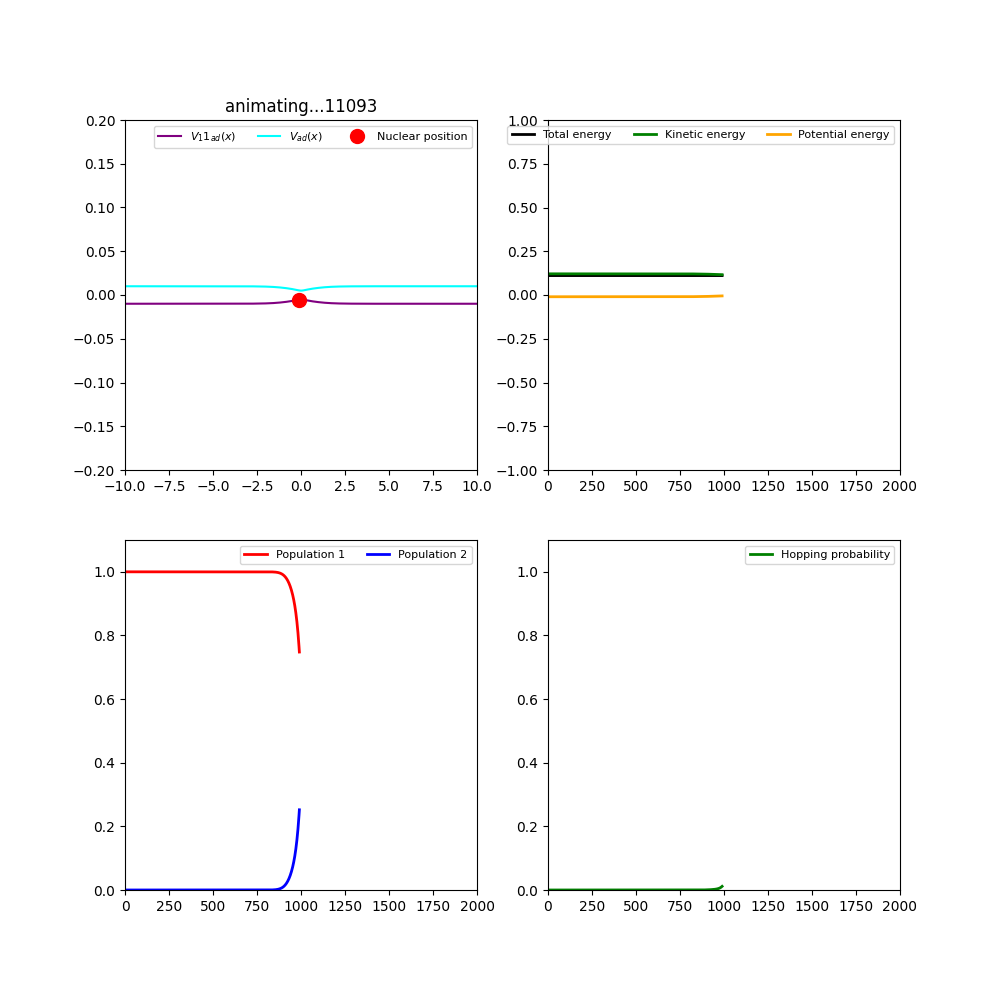

Button(description='Play', style=ButtonStyle())

In [3]:
def init():
   
    V1_ad_x_line.set_data([],[])
    V2_ad_x_line.set_data([],[])
    tot_e_line.set_data([],[])
    ke_line.set_data([],[])
    pe_line.set_data([],[])
    pop1_line.set_data([],[])
    pop2_line.set_data([],[])
    prob_line.set_date([],[])

   
    title.set_text("Title")
    
    return V1_ad_x_line,V2_ad_x_line,pop1_line,pop2_line



fig = plt.figure(figsize=(10,10))
fig.canvas.header_visible = True
# plotting limits
xlim = (-10, 10)
# tlim = (0,S.tot_steps)
Nx = 1000
N_steps = 2000


x = np.linspace(-10,10,Nx)
pes = np.zeros((Nx,2))

for i,pos in enumerate(x):
    
    V = pe_model.V(pos)
#     print(V)
    energy_arr, coeffs = np.linalg.eigh(V)
    pes[i,:] = np.array(energy_arr)


# ymin = 0.
# if pot_select.index == 0:
#     ymax = 1.0 
#     ylims=(ymin - 0.2 * (ymax - ymin),
#                             ymax + 0.2 * (ymax - ymin))
# else:
xlim=(-10,10)
ylims=(-0.2,0.2)
    
Elims=(-1,1)
poplims=(0,1.1) 
tlims=(0,N_steps)
ax1 = fig.add_subplot(221, xlim=xlim,
                      ylim=ylims)
ax2 = fig.add_subplot(222, xlim=tlims,
                      ylim=Elims)

# subplot for populations
ax3 = fig.add_subplot(223, xlim=tlims,
                      ylim=poplims)

ax4 = fig.add_subplot(224, xlim=tlims, ylim=poplims)

# psi1_x_line, = ax1.plot([], [], c='r', label=r'$|c_1(x)|$', linewidth=1.2)

V1_ad_x_line, = ax1.plot([], [], c='purple', label=r'$V_11_{ad}(x)$')
V2_ad_x_line, = ax1.plot([], [], c='cyan', label=r'$V_{ad}(x)$')#
V1_ad_x_line.set_data(x,pes[:,0])
V2_ad_x_line.set_data(x,pes[:,1])       
pos_marker, = ax1.plot([], [], 'ro', ms=10, label='Nuclear position')
      
tot_e_line, = ax2.plot([], [], c='black', label=r'Total energy', linewidth=2.0)
ke_line, = ax2.plot([], [], c='green', label=r'Kinetic energy', linewidth=2.0)
pe_line, = ax2.plot([], [], c='orange', label=r'Potential energy', linewidth=2.0)
pop1_line, = ax3.plot([], [], c='red', label=r'Population 1', linewidth=2.0)
pop2_line, = ax3.plot([], [], c='blue', label=r'Population 2', linewidth=2.0)
prob_line, = ax4.plot([], [], c='green', label=r'Hopping probability', linewidth=2.0)

title = ax1.set_title("")
ax1.legend(prop=dict(size=8), ncol=4, loc=1)
ax2.legend(prop=dict(size=8), ncol=4, loc=1)
ax3.legend(prop=dict(size=8), ncol=4, loc=1)
ax4.legend(prop=dict(size=8), ncol=4, loc=1)

           


def animate(i):
    global title, output,fs, step, N_steps
    global tot_e_list, ke_list, pe_list,pop1_list, pop2_list, prob_list #, pop1_line, pop2_line
    # can just set pause = True after each step in the algo
    
    Nx = 1000
    x = np.linspace(-10,10,Nx)
    
    if step<N_steps:  
        
        fs.run_single_step()
#         
        p1 = fs.p1
        p2 = fs.p2
        pop1_list.append(p1)
        pop2_list.append(p2)
        tot_e_list.append(fs.tot_e)
        pe_list.append(fs.pe)
        ke_list.append(fs.ke)
        prob_list.append(fs.P)
#         pop1_list.append(np.linalg.norm(p1))
# #         with output:
# #             print("pop1_list = {}".format(pop1_list))
#         pop2_list.append(np.linalg.norm(p2))
        step+=1
    else:
        time=0.
        step = 0
        ndim=1
        num_states=2
        # specify constants
        hbar = 1.0   # planck's constant
        mass = 2000.      # particle mass
        F = 0.
        momentum = 22.0
        vel = momentum/mass
        dt=0.01/vel
        pe_model = tully1()
        
        
        N_steps = 2000
        t_max = 120
        
        
        V = np.zeros((2,2))
        dV = np.zeros((2,2))
        elec_energies = np.zeros(2)
        elec_coeffs = np.array([1,0])
        nuc_pos=-10.0
        
        fs = FSSH(pe_model, nuc_pos, vel, mass, dt)
       
        tot_e_list = []
        ke_list = []
        pe_list = []
        pop1_list = []
        pop2_list = []
        prob_list = []
    

    V1_ad_x_line.set_data(x,pes[:,0])
    V2_ad_x_line.set_data(x,pes[:,1]) 
    tot_e_line.set_data(np.arange(step),tot_e_list)
    pe_line.set_data(np.arange(step),pe_list)
    ke_line.set_data(np.arange(step),ke_list)
    pop1_line.set_data(np.arange(step),pop1_list)
    pop2_line.set_data(np.arange(step),pop2_list)
    prob_line.set_data(np.arange(step),prob_list)
    

    pos_marker.set_data(fs.nuc_pos,fs.elec_energies[fs.current_state]) # draw marker on active surface

#     pos_marker.set_data(nuc_pos,elec_energies[0]) # draw marker on active surface
#     pos_marker.set_data(0,0)


    title.set_text("animating...{}".format(i))

    return  V1_ad_x_line,  V2_ad_x_line, pos_marker, pop1_line, pop2_line, title


tot_e_list = []
ke_list = []
pe_list = []
pop1_list = []
pop2_list = []
prob_list = []





anim = animation.FuncAnimation(fig, animate,frames=N_steps*N_trajs, interval=0.1, blit=False,repeat=True)
#fig.show()

def onClick(event):
    global pause
    pause ^= True
    with output:
        print("onClick")
    
    if button_pause.description == "Pause":
        button_pause.description = "Play"
        print("pausing")

        anim.event_source.stop()
    else:
        button_pause.description = "Pause"
        with output:
            print("playing")
        anim.event_source.start()
       


button_pause = Button(description="Play");
button_pause.on_click(onClick)
display(button_pause);

In [4]:
display(output)

Output(layout=Layout(width='400px'))